In [1]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

sys.path.append("/Users/nickkeesey/Desktop/learning-dynamics-behavior/src/utils")
import behavior_utils as bu


from aind_behavior_gym.dynamic_foraging.task import CoupledBlockTask

refrence_df = pd.read_csv("/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/filtered_data_20241107.csv")

/var/folders/mr/k7gx9xps333170k7zsggl4tw0000gn/T/ipykernel_4411/3494160968.py:14: DtypeWarning: Columns (6,7,8,11,26,27,28,29,30,133,134,149,150,151,152,153,154,155,156,157,158,159,160,161) have mixed types. Specify dtype option on import or set low_memory=False.
  refrence_df = pd.read_csv("/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/filtered_data_20241107.csv")


In [2]:
refrence_df

,subject_id,session_date,nwb_suffix,session,rig,user_name,curriculum_name,curriculum_version,current_stage_actual,task,...,subject_genotype,fiber_probes,injections,task_type,virus,NM_recorded,results,results_location,session_time,docDB_status
0,743794,2024-11-06,173429,31.0,447-2-C,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,wt/wt,[],[],Uncoupled Baiting,[],[],behavior_743794_2024-11-06_17-34-29_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/5...,17-34-29,2_uploaded and processed
1,741210,2024-11-06,173034,35.0,447-3-D,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,wt/wt,[],[],Uncoupled Baiting,[],[],behavior_741210_2024-11-06_17-30-34_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/b...,17-30-34,2_uploaded and processed
2,728568,2024-11-06,172930,31.0,447-3-C,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,Oi8(H11-CAG-Cas9)/Oi8(H11-CAG-Cas9),[],[],Uncoupled Baiting,[],[],behavior_728568_2024-11-06_17-29-30_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/1...,17-29-30,2_uploaded and processed
3,745505,2024-11-06,172625,11.0,447-1-D,Bowen Tan,Uncoupled Baiting,2.3,STAGE_FINAL,Uncoupled Baiting,...,Drd1a-Cre/wt;Adora2a-T2A-FlpO/wt;Ai231(TICL-Ch...,[],[],Uncoupled Baiting,[],[],behavior_745505_2024-11-06_17-26-25_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/d...,17-26-25,2_uploaded and processed
4,745502,2024-11-06,172512,15.0,447-1-C,Bowen Tan,Uncoupled Baiting,2.3,STAGE_FINAL,Uncoupled Baiting,...,Drd1a-Cre/wt;Adora2a-T2A-FlpO/wt;Ai231(TICL-Ch...,[],[],Uncoupled Baiting,[],[],behavior_745502_2024-11-06_17-25-12_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/9...,17-25-12,2_uploaded and processed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9078,453478,2019-06-26,164352,2.0,Training-Tower-2_bpod,Marton Rozsa,NaN,NaN,NaN,Coupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded
9079,453476,2019-06-25,213144,1.0,Training-Tower-2_bpod,Marton Rozsa,NaN,NaN,NaN,Coupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded
9080,453477,2019-06-25,201839,1.0,Training-Tower-2_bpod,Marton Rozsa,NaN,NaN,NaN,Coupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded
9081,453475,2019-06-25,190736,1.0,Training-Tower-2_bpod,Marton Rozsa,NaN,NaN,NaN,Coupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded


In [3]:
URL = "https://api.allenneuraldynamics-test.org/v1/behavior_analysis/mle_fitting"

filter = {
    # "nwb_name": "720956_2024-07-17_13-02-47.nwb",  # Session id,
    "analysis_results.fit_settings.agent_alias": "QLearning_L2F1_softmax",  # Hattori2019 model
}
projection = {
    "analysis_results.params": 1,
    "nwb_name": 1,  # Include session ID in projection
    "_id": 0,
}
response = requests.get(URL, params={"filter": json.dumps(filter), "projection": json.dumps(projection), "limit": 100})
record_dict = response.json()

# Fitted parameters
# params = record_dict["analysis_results"]["params"]

# Convert list of dicts to dataframe with session ID
df = pd.DataFrame([{
    **x['analysis_results']['params'],
    'session_id': x['nwb_name']  # Add session ID column
} for x in record_dict])

In [4]:
# Split session_id into subject_id and session_date
df[['subject_id', 'session_date']] = df['session_id'].str.extract(r'(\d+)_(\d{4}-\d{2}-\d{2})')

# Drop the original session_id column
df = df.drop('session_id', axis=1)

# Reorder columns to put subject_id and session_date first
cols = ['subject_id', 'session_date'] + [col for col in df.columns if col not in ['subject_id', 'session_date']]
df = df[cols]

# Convert subject_id to int64 and session_date to datetime
df['subject_id'] = df['subject_id'].astype('int64')
df['session_date'] = pd.to_datetime(df['session_date'])

df.sort_values(by=['subject_id', 'session_date'], inplace=True)

df

,subject_id,session_date,learn_rate_rew,learn_rate_unrew,forget_rate_unchosen,biasL,softmax_inverse_temperature
57,671087,2023-07-18,0.684853,0.072071,0.481018,-1.349655,5.034687
85,676747,2023-10-13,0.081141,0.605415,1.000000,-2.552808,55.284152
99,680599,2023-10-05,0.312631,0.223942,1.000000,-0.377754,4.035622
11,684039,2023-11-14,0.237261,0.953112,0.568157,-0.759839,82.467814
26,684039,2023-11-27,0.377765,0.269694,0.890007,-2.213424,10.997112
...,...,...,...,...,...,...,...
12,743797,2024-08-15,0.761404,0.091360,0.489577,-0.087088,3.414245
28,744744,2024-09-11,0.826565,0.054588,0.498369,0.546750,2.119710
56,750101,2024-08-19,0.220896,0.032371,0.374618,0.442092,2.406698
1,750102,2024-08-29,0.816178,0.170029,1.000000,-0.031476,4.312851


In [5]:
print(len(df['subject_id'].unique()))

68


In [6]:
merged_df = bu.merge_dataframes_subject_id(refrence_df, df)
merged_df

,subject_id,session_date,nwb_suffix,session,rig,user_name,curriculum_name,curriculum_version,current_stage_actual,task,...,NM_recorded,results,results_location,session_time,docDB_status,learn_rate_rew,learn_rate_unrew,forget_rate_unchosen,biasL,softmax_inverse_temperature
0,741211,2024-09-18,173004,20.0,447-3-C,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,[],behavior_741211_2024-09-18_17-30-04_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/3...,17-30-04,2_uploaded and processed,0.306859,0.295367,0.713393,1.307859,5.735181
1,724172,2024-09-16,114638,25.0,323_EPHYS1,Ella Hilton,Uncoupled Without Baiting,2.2.1rwdDelay159,STAGE_FINAL,Uncoupled Without Baiting,...,NaN,NaN,NaN,NaN,0_not uploaded,0.346859,0.173688,0.742682,0.007129,6.866458
2,733683,2024-09-12,92030,10.0,446-8-B,Ella Hilton,Uncoupled Without Baiting,2.2.1rwdDelay159,STAGE_3,Coupled Without Baiting,...,"['NE', 'NE']",behavior_733683_2024-09-12_09-20-30_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/3...,09-20-30,2_uploaded and processed,0.728892,0.318346,0.949562,-0.178817,4.479776
3,744744,2024-09-11,91258,8.0,447-1-B,Huy Nguyen,Uncoupled Baiting,2.3,STAGE_FINAL,Uncoupled Baiting,...,[],behavior_744744_2024-09-11_09-12-58_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/1...,09-12-58,2_uploaded and processed,0.826565,0.054588,0.498369,0.546750,2.119710
4,753124,2024-09-06,90233,7.0,446-7-C,margaret lee,Uncoupled Baiting,2.3,STAGE_FINAL,Uncoupled Baiting,...,[],behavior_753124_2024-09-06_09-02-33_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/8...,09-02-33,2_uploaded and processed,0.560053,0.028897,0.057833,0.152873,4.450795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,684891,2023-10-05,0,5.0,Red-3,Travis Ramirez,NaN,NaN,NaN,Uncoupled Without Baiting,...,NaN,NaN,NaN,NaN,0_not uploaded,0.389234,0.031246,0.554898,-0.062239,3.194765
92,684890,2023-10-05,0,7.0,Red-2,Travis Ramirez,NaN,NaN,NaN,Uncoupled Without Baiting,...,NaN,NaN,NaN,NaN,0_not uploaded,0.662058,0.312680,1.000000,-0.083287,4.164813
93,680599,2023-10-05,0,6.0,Red-1,Avalon Amaya,NaN,NaN,NaN,Coupled Baiting,...,NaN,NaN,NaN,NaN,0_not uploaded,0.312631,0.223942,1.000000,-0.377754,4.035622
94,685642,2023-09-18,0,4.0,Tower-1,Lucas Kinsey,NaN,NaN,NaN,Uncoupled Without Baiting,...,NaN,NaN,NaN,NaN,0_not uploaded,0.355054,0.005164,0.484957,-0.582579,4.686825


In [7]:
merged_df['curriculum_name'].unique()

array(['Uncoupled Baiting', 'Uncoupled Without Baiting', nan,
       'Coupled Baiting'], dtype=object)

In [8]:
curriculum_name = 'Coupled Baiting'

final_df = merged_df[merged_df['curriculum_name'] == curriculum_name]
final_df

,subject_id,session_date,nwb_suffix,session,rig,user_name,curriculum_name,curriculum_version,current_stage_actual,task,...,NM_recorded,results,results_location,session_time,docDB_status,learn_rate_rew,learn_rate_unrew,forget_rate_unchosen,biasL,softmax_inverse_temperature
17,724555,2024-07-18,131230,20.0,447-1-B,Jaimie Kenney,Coupled Baiting,2.2,GRADUATED,Coupled Baiting,...,NaN,NaN,NaN,NaN,0_not uploaded,0.017865,0.441835,1.000000,-0.498097,97.613373
28,700708,2024-06-21,84302,50.0,447-1-D,Huy Nguyen,Coupled Baiting,2.2,STAGE_2,Coupled Baiting,...,"['-3.05,-0.6,-4.3', 'DA']",behavior_700708_2024-06-21_08-43-02_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/3...,08-43-02,2_uploaded and processed,0.358205,0.341702,0.541927,0.085392,8.212057
29,724555,2024-06-20,134643,4.0,447-1-B,Jaimie Kenney,Coupled Baiting,2.2,STAGE_1,Coupled Baiting,...,[],NaN,NaN,13-46-43,1_uploaded but not processed,0.772795,0.300758,0.989745,-0.639562,4.955060
40,700708,2024-05-22,112048,33.0,447-1-D,Huy Nguyen,Coupled Baiting,2.1,STAGE_2,Coupled Baiting,...,NaN,NaN,NaN,NaN,0_not uploaded,0.731637,0.132131,0.677929,-0.911891,3.736680
57,714314,2024-04-17,133724,8.0,447-1-B,Huy Nguyen,Coupled Baiting,1.0,STAGE_2,Coupled Baiting,...,NaN,NaN,NaN,NaN,0_not uploaded,0.662271,0.218630,1.000000,-0.660032,4.106454
60,714314,2024-04-10,143852,3.0,447-2-B,Huy Nguyen,Coupled Baiting,1.0,STAGE_1,Coupled Baiting,...,NaN,NaN,NaN,NaN,0_not uploaded,0.470382,0.297813,0.830019,0.198252,4.030940
62,722680,2024-04-01,113309,1.0,447-1-C,Travis Ramirez,Coupled Baiting,1.0,STAGE_1_WARMUP,Coupled Baiting,...,NaN,NaN,NaN,NaN,0_not uploaded,0.101492,0.073585,0.063839,0.789775,2.965879


In [9]:
from fc_environments import run_task_env
import seaborn as sns

results_df = run_task_env(final_df, n_sims=1000)
results_df

Running 1000 simulations for parameter set 18/7 (GRADUATED): 100%|██████████| 1000/1000 [00:16<00:00, 62.47it/s]
Running 1000 simulations for parameter set 29/7 (STAGE_2): 100%|██████████| 1000/1000 [00:07<00:00, 128.16it/s]
Running 1000 simulations for parameter set 30/7 (STAGE_1): 100%|██████████| 1000/1000 [00:07<00:00, 132.59it/s]
Running 1000 simulations for parameter set 41/7 (STAGE_2): 100%|██████████| 1000/1000 [00:07<00:00, 126.89it/s]
Running 1000 simulations for parameter set 58/7 (STAGE_2): 100%|██████████| 1000/1000 [00:08<00:00, 124.56it/s]
Running 1000 simulations for parameter set 61/7 (STAGE_1): 100%|██████████| 1000/1000 [00:07<00:00, 130.50it/s]

,parameter_set,stage,simulation,foraging_efficiency,foraging_efficiency_random_seed,foraging_choice_local,foraging_choice_global,random_seed,num_trials,block_min,block_max,block_beta,learn_rate_rew,learn_rate_unrew,forget_rate_unchosen,biasL,softmax_inverse_temperature
0,17,GRADUATED,0,0.856694,0.840426,0.189391,0.236190,42,450,20,60,20,0.017865,0.441835,1.000000,-0.498097,97.613373
1,17,GRADUATED,1,0.868767,0.845745,0.191484,0.151746,43,450,20,60,20,0.017865,0.441835,1.000000,-0.498097,97.613373
2,17,GRADUATED,2,0.843139,0.847826,0.157153,0.177778,44,450,20,60,20,0.017865,0.441835,1.000000,-0.498097,97.613373
3,17,GRADUATED,3,0.908829,0.808824,0.218982,0.186667,45,450,20,60,20,0.017865,0.441835,1.000000,-0.498097,97.613373
4,17,GRADUATED,4,0.866196,0.855615,0.255675,0.214603,46,450,20,60,20,0.017865,0.441835,1.000000,-0.498097,97.613373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,60,STAGE_1,995,0.737500,0.742138,0.266792,0.410000,1037,200,10,20,5,0.470382,0.297813,0.830019,0.198252,4.030940
5996,60,STAGE_1,996,0.712500,0.712500,0.390293,0.400000,1038,200,10,20,5,0.470382,0.297813,0.830019,0.198252,4.030940
5997,60,STAGE_1,997,0.743750,0.753165,0.530174,0.500000,1039,200,10,20,5,0.470382,0.297813,0.830019,0.198252,4.030940
5998,60,STAGE_1,998,0.606250,0.638158,0.250873,0.250000,1040,200,10,20,5,0.470382,0.297813,0.830019,0.198252,4.030940


<Axes: xlabel='learn_rate_rew', ylabel='foraging_choice_local'>

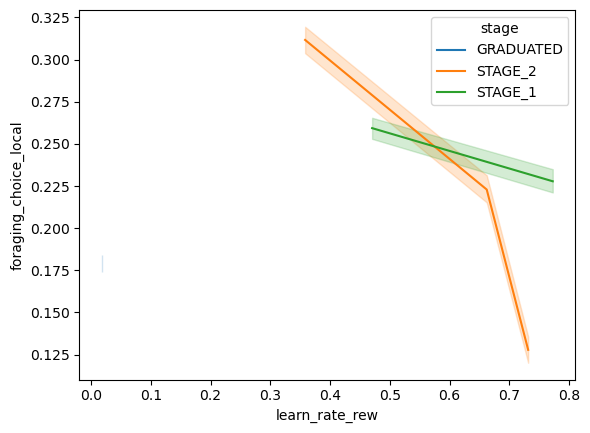

In [10]:
sns.lineplot(results_df, x='learn_rate_rew', y='foraging_choice_local', hue='stage')

/var/folders/mr/k7gx9xps333170k7zsggl4tw0000gn/T/ipykernel_4411/4117725290.py:7: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  local_pivot = pd.pivot_table(
/var/folders/mr/k7gx9xps333170k7zsggl4tw0000gn/T/ipykernel_4411/4117725290.py:15: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  global_pivot = pd.pivot_table(


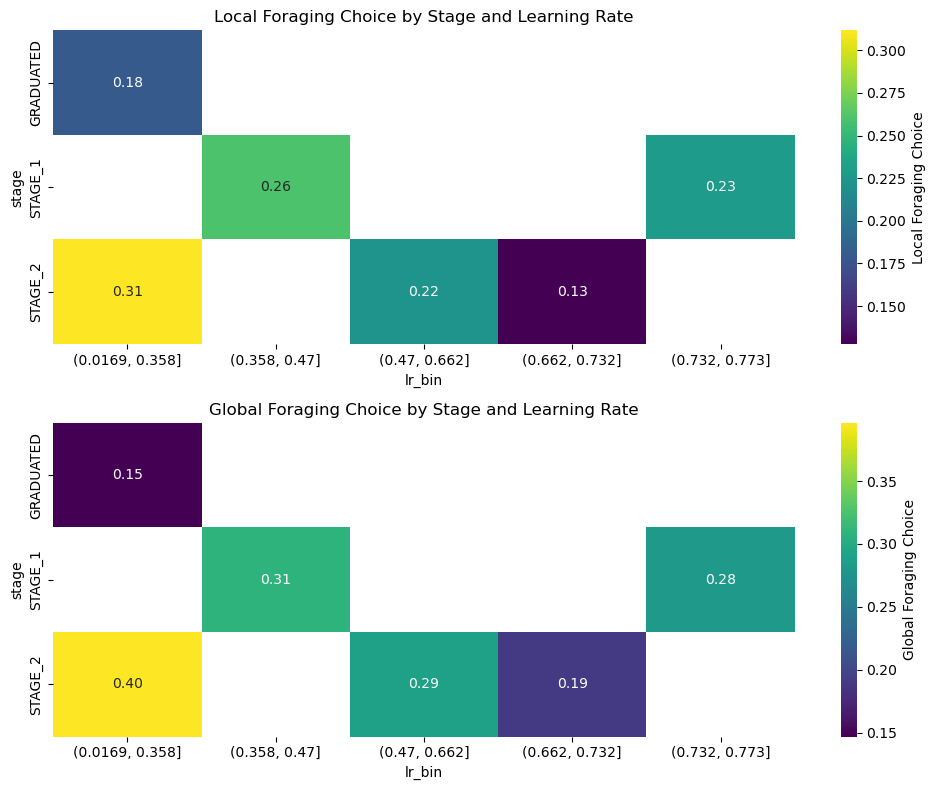

In [11]:
import seaborn as sns


results_df['lr_bin'] = pd.qcut(results_df['learn_rate_rew'], q=5, duplicates='drop')

# Create pivot tables for both metrics
local_pivot = pd.pivot_table(
    results_df, 
    values='foraging_choice_local',
    index='stage',
    columns='lr_bin',
    aggfunc='mean'
)

global_pivot = pd.pivot_table(
    results_df, 
    values='foraging_choice_global',
    index='stage',
    columns='lr_bin',
    aggfunc='mean'
)

# Plot heatmaps
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

sns.heatmap(local_pivot, ax=ax1, cmap='viridis', 
            annot=True, fmt='.2f', cbar_kws={'label': 'Local Foraging Choice'})
ax1.set_title('Local Foraging Choice by Stage and Learning Rate')

sns.heatmap(global_pivot, ax=ax2, cmap='viridis',
            annot=True, fmt='.2f', cbar_kws={'label': 'Global Foraging Choice'})
ax2.set_title('Global Foraging Choice by Stage and Learning Rate')

plt.tight_layout()
plt.show()


In [12]:
# Starting with Coupled Baiting Block Task

stage_vector = ['STAGE_1', 'STAGE_2', 'STAGE_3', 'STAGE_FINAL', 'GRADUATED']

# Base off streamlit or bonsai data?

STAGE_1 = CoupledBlockTask(
    reward_baiting=True, 
    num_trials= 200,
    block_min = 10,
    block_max = 20,
    block_beta = 5,
    p_reward_pairs = [
        [0.8, 0]
    ],
    seed=42
)

STAGE_2 = CoupledBlockTask(
    reward_baiting=True, 
    num_trials= 200,
    block_min = 10,
    block_max = 40,
    block_beta = 10,
    p_reward_pairs = [
        [0.55, 0.05]
    ],
    seed=42
)

STAGE_3 = CoupledBlockTask(
    reward_baiting=True, 
    num_trials= 300,
    block_min = 20,
    block_max = 60,
    block_beta = 20,
    p_reward_pairs = [
        [0.4, 0.05]
    ],
    seed=42
)

STAGE_FINAL = CoupledBlockTask(
    reward_baiting=True, 
    num_trials= 400,
    block_min = 20,
    block_max = 60,
    block_beta = 20,
    p_reward_pairs = [
        [0.4, 0.05],
        [0.25, 0.2],
        [0.1, 0.35],
        [0.3, 0.15]
    ],
    seed=42
)

GRADUATED = CoupledBlockTask(
    reward_baiting=True, 
    num_trials= 450,
    block_min = 20,
    block_max = 60,
    block_beta = 20,
    p_reward_pairs = [
        [0.4, 0.05],
        [0.25, 0.2],
        [0.1, 0.35],
        [0.3, 0.15]
    ],
    seed=42
)

tasks = {
    'STAGE_1': STAGE_1,
    'STAGE_2': STAGE_2,
    'STAGE_3': STAGE_3,
    'STAGE_FINAL': STAGE_FINAL,
    'GRADUATED': GRADUATED
}

/var/folders/mr/k7gx9xps333170k7zsggl4tw0000gn/T/ipykernel_4411/2696116307.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_by_bin = results_df.groupby(['stage', 'lr_bin']).agg({


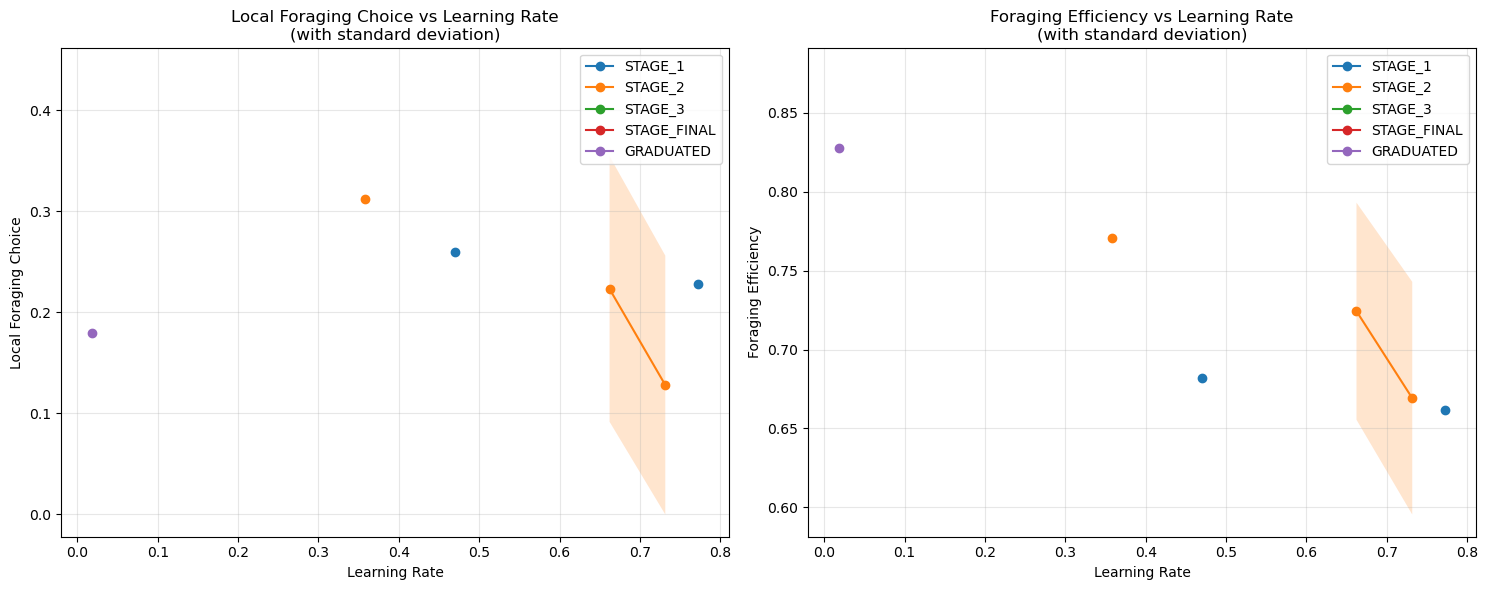

In [13]:
# 1. Line plot with confidence intervals
plt.figure(figsize=(15, 6))

# Create bins for learning rate to smooth the plot
results_df['lr_bin'] = pd.qcut(results_df['learn_rate_rew'], q=5, duplicates='drop')
mean_by_bin = results_df.groupby(['stage', 'lr_bin']).agg({
    'learn_rate_rew': 'mean',
    'foraging_choice_local': ['mean', 'std'],
    'foraging_efficiency': ['mean', 'std']
}).reset_index()

# Plot for local metric
plt.subplot(1, 2, 1)
for stage in tasks.keys():
    stage_data = mean_by_bin[mean_by_bin['stage'] == stage]
    plt.plot(stage_data[('learn_rate_rew', 'mean')], 
             stage_data[('foraging_choice_local', 'mean')], 
             label=stage, marker='o')
    plt.fill_between(stage_data[('learn_rate_rew', 'mean')],
                     stage_data[('foraging_choice_local', 'mean')] - stage_data[('foraging_choice_local', 'std')],
                     stage_data[('foraging_choice_local', 'mean')] + stage_data[('foraging_choice_local', 'std')],
                     alpha=0.2)

plt.xlabel('Learning Rate')
plt.ylabel('Local Foraging Choice')
plt.title('Local Foraging Choice vs Learning Rate\n(with standard deviation)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot for foraging efficiency
plt.subplot(1, 2, 2)
for stage in tasks.keys():
    stage_data = mean_by_bin[mean_by_bin['stage'] == stage]
    plt.plot(stage_data[('learn_rate_rew', 'mean')], 
             stage_data[('foraging_efficiency', 'mean')], 
             label=stage, marker='o')
    plt.fill_between(stage_data[('learn_rate_rew', 'mean')],
                     stage_data[('foraging_efficiency', 'mean')] - stage_data[('foraging_efficiency', 'std')],
                     stage_data[('foraging_efficiency', 'mean')] + stage_data[('foraging_efficiency', 'std')],
                     alpha=0.2)

plt.xlabel('Learning Rate')
plt.ylabel('Foraging Efficiency')
plt.title('Foraging Efficiency vs Learning Rate\n(with standard deviation)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()